# Plot temperature response over time

This notebook plots temperature respons to SLCFs AND the total scenario forcing in a fixed nr of years

## Imports:

In [1]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import os
import re
from pathlib import Path
import pandas as pd
import tqdm
from scmdata import df_append, ScmDataFrame
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
from ar6_ch6_rcmipfigs.constants import BASE_DIR
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR, RESULTS_DIR

PATH_DT = OUTPUT_DATA_DIR + '/dT_data_rcmip_models.nc'

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in


## Set values:

In [3]:
first_y ='1850'
last_y = '2100'
# Years to plot:
years = ['2040', '2100']

**Set reference year for temperature change:**

In [4]:
ref_year = '2021'

In [5]:
FIGURE_DIR = RESULTS_DIR + '/figures/'

In [6]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [7]:
from ar6_ch6_rcmipfigs.utils.misc_func import new_varname

# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
                # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']
scenarios_nhist = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                   # 'ssp370-lowNTCF', Due to mistake here
                   'ssp585']  # list(set(scenarios_fl)- {'historical'})
climatemodels_fl = ['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT', 'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0']

# List of delta T for variables
name_deltaT = 'Delta T'
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]

In [8]:

variables_tot = ['Total']
variables_sum = ['Sum SLCFs']

def setup_table_prop(scenario_n='', years=None, variabs=None, scens=None):
    if variabs is None:
        variabs = [var.split('|')[-1] for var in variables_erf_comp]
    if years is None:
        years = ['2040', '2100']
    if scens is None:
        scens = scenarios_nhist
    its = [years, variabs]
    _i = pd.MultiIndex.from_product(its, names=['', ''])
    table = pd.DataFrame(columns=scens, index=_i)  # .transpose()
    table.index.name = scenario_n
    return table

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [9]:
ds_DT = xr.open_dataset(PATH_DT)

## Compute sum of all SLCF forcers

In [10]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, get_scenario_ls_dic

In [11]:

s_y = first_y

cdic = get_scenario_c_dic()  # get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()  # _scget_ls_dic(ds_DT[climatemodel].values)

def sum_name(var):
    """
    Returns the name off the sum o
    """
    return '|'.join(var.split('|')[0:2]) + '|' + 'All'



# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
# Make list of dataArrays to be concatinated:
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
# Name of new var:
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
# Name of new var:
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))
dt_totn = dt_all

In [12]:
scntab_dic = {}


# tab_tot = setup_table2()
# tab_tot_sd = setup_table2()
def table_of_sts(ds_DT, scenarios_nhist, variables, tab_vars, years, ref_year, sts='mean'):
    """
    Creates pandas dataframe of statistics (mean, median, standard deviation) for change
    in temperature Delta T since year (ref year) for each scenario in scenarios,

    :param ds_DT:
    :param scenarios_nhist:
    :param variables:
    :param tab_vars:
    :param years:
    :param ref_year:
    :param sts:
    :return:
    """
    tabel = setup_table_prop(years=years, variabs=tab_vars)
    for scn in scenarios_nhist:
        for var, tabvar in zip(variables, tab_vars):
            dtvar = new_varname(var, name_deltaT) # if ERF name, changes it here.
            tabscn = scn  # Table scenario name the same.
            for year in years:
                _da =ds_DT[dtvar].sel(scenario=scn)
                _da_refy = _da.sel(time=slice(ref_year, ref_year)).squeeze() # ref year value
                _da_y = _da.sel(time=slice(year, year)) # year value
                _tab_da = _da_y - _da_refy
                #_tab_da = ds_DT[dtvar].sel(scenario=scn, time=slice(year, year)) - ds_DT[dtvar].sel(scenario=scn,
                #                                                                                    time=slice(ref_year,
                #                                                                                               ref_year)).squeeze()

                # Do statistics over RCMIP models
                if sts == 'mean':
                    tabel.loc[(year, tabvar), tabscn] = _tab_da.mean('climatemodel').values[0]
                if sts == 'median':
                    tabel.loc[(year, tabvar), tabscn] = _tab_da.median('climatemodel').values[0]
                elif sts == 'std':
                    tabel.loc[(year, tabvar), tabscn] = _tab_da.std('climatemodel').values[0]

    return tabel

def table_of_stats_varsums(ds_DT, scenarios_nhist, dsvar, tabvar, years, ref_year, sts='mean'):
    """
    Sums up over dimension 'variable' and creates pandas dataframe of statistics (mean, median, standard deviation) for change
    in temperature Delta T since year (ref year) for each scenario in scenarios. 

    :param ds_DT:
    :param scenarios_nhist:
    :param variables:
    :param tab_vars:
    :param years:
    :param ref_year:
    :param sts:
    :return:
    """
    tabel = setup_table_prop(years=years, variabs=[tabvar])
    da = ds_DT[dsvar]
    if sts=='mean':
        da = ds_DT[dsvar]#.mean('climatemodel').sum('variable')
    if sts == 'median':
        da = ds_DT[dsvar]#.median('climatemodel').sum('variable')
    elif sts=='std':
        da = ds_DT[dsvar]#.sum('variable').std('climatemodel')
    for scn in scenarios_nhist:
        #for var, tabvar in zip(variables, tab_vars):
        dtvar = new_varname(dsvar, name_deltaT) # if ERF name, changes it here.
        tabscn = scn  # Table scenario name the same.
        for year in years:
            _da =da.sel(scenario=scn)
            _da_refy = _da.sel(time=slice(ref_year, ref_year)).squeeze() # ref year value
            _da_y = _da.sel(time=slice(year, year)).squeeze() # year value
            _tab_da = (_da_y - _da_refy).squeeze()
            if sts=='mean':
                _tab_da = _tab_da.mean('climatemodel').sum('variable')
            elif sts == 'median':
                _tab_da = _tab_da.median('climatemodel').sum('variable')
            elif sts=='std':
                _tab_da= _tab_da.sum('variable').std('climatemodel')

            # Do statistics over RCMIP models
            tabel.loc[(year, tabvar), tabscn] = _tab_da.values

    return tabel

### Computes statistics:

In [13]:
# Statistics on Delta T anthropogenic
# Mean
tabel_dT_anthrop = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year)
# Standard deviation
tabel_dT_anthrop_SD = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year, sts='std')
# Mean:
tabel_dT_slcfs = table_of_sts(ds_DT, scenarios_nhist, variables_dt_comp, [var.split('|')[-1] for var in variables_dt_comp], years,
                              ref_year)
# Standard deviation
tabel_dT_slcfs_DF = table_of_sts(ds_DT, scenarios_nhist, variables_dt_comp, [var.split('|')[-1] for var in variables_dt_comp],
                                 years, ref_year, sts='std')
# Compute sum of SLCFs
_ds = ds_DT.copy()
vall = 'Delta T|Anthropogenic|All'
_ds[vall] = _ds[vall].sum('variable')
#tabel_dT_sum_slcf = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year)
#tabel_dT_sum_slcf_SD = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='std')

In [14]:
tabel_dT_sum_slcf = table_of_stats_varsums(ds_DT, scenarios_nhist, vall, 'Sum SLCFs', years, ref_year)
tabel_dT_sum_slcf_SD = table_of_stats_varsums(ds_DT, scenarios_nhist, vall, 'Sum SLCFs', years, ref_year, sts='std')
tabel_dT_sum_slcf_SD

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden,ssp585
,,,,,,,,
2040,Sum SLCFs,0.10684343548179748,0.08529145407800068,0.04831220630757891,0.025785552790189827,0.06398027899234776,0.06007755097970012,0.05253533762557518
2100,Sum SLCFs,0.1297791963664601,0.14035522920526422,0.11358809497353772,0.10731891440382212,0.1686480511004645,0.14044266035549746,0.1580167611267991


## Error bars only from model uncertainty
The following uncertainties assume the ECS has a standard deviation of

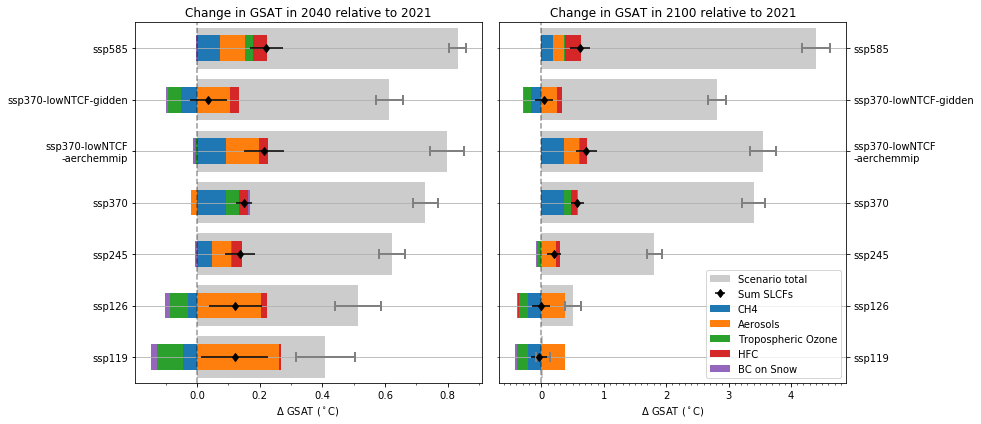

In [15]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[12, 6], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    # Pick out year and do various renames:
    # Total antropogenic
    tot_yr = tabel_dT_anthrop.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = tabel_dT_anthrop_SD.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Sum SLCFs
    sum_yr = tabel_dT_sum_slcf.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = tabel_dT_sum_slcf_SD.loc[yr].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Plot bars for anthropopogenic total:
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            xerr=tot_sd_yr.transpose()[ntot].values,
            error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    # Plot bars for SLCFs total:
    ntot = 'Sum SLCFs'
    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values
    s_err = sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_y, s_x, xerr=s_err, label=ntot, color='k', fmt='d', linestyle="None")  # ,

    # Plot stacked plot of components:
    _tab = tabel_dT_slcfs.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend()  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    # Zero line:
    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')

fn = RESULTS_DIR + '/figures/stack_bar_influence_years_mod_spread_ONLY.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y', which='minor')  # ,bottom='off')
ax.tick_params(labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)

## Error bars from model uncertainty AND ECS uncertainty

See [Uncertainty_calculation.ipynb](Uncertainty_calculation.ipynb)

In [16]:
def sigma_DT(dT, sig_alpha, mu_alpha, dim='climatemodel'):
    sig_DT = dT.std(dim)
    mu_DT = dT.mean(dim)
    return ((sig_DT + mu_DT) * (sig_alpha + mu_alpha) - mu_DT * mu_alpha) / mu_alpha


def sigma_com(sig_DT, mu_DT, sig_alpha, mu_alpha):
    return (((sig_DT ** 2 + mu_DT ** 2) * (
            sig_alpha ** 2 + mu_alpha ** 2) - mu_DT ** 2 * mu_alpha ** 2) / mu_alpha ** 2) ** .5


sum_DT_std =  table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='std')
sum_DT_mean = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='mean')
tot_DT_std = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year, sts='std')
tot_DT_mean = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year, sts='mean')

yerr_sum = sigma_com(sum_DT_std, sum_DT_mean, .24, .885)
yerr_tot = sigma_com(tot_DT_std, tot_DT_mean, .24, .885)  # .rename('')

# tab_sig_DT = setup_table_prop()

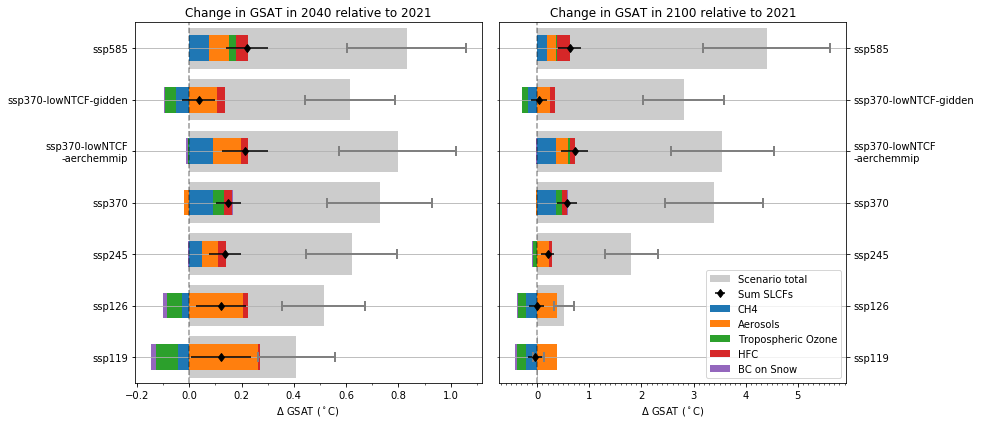

In [17]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[12, 6], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tabel_dT_anthrop.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = yerr_tot.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tabel_dT_sum_slcf.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = yerr_sum.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            xerr=tot_sd_yr.transpose()[ntot].values,
            error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    # ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values
    s_err = sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_y, s_x, xerr=s_err, label=ntot, color='k', fmt='d', linestyle="None")  # ,
    # error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tabel_dT_slcfs.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend()  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')

    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')

fn = RESULTS_DIR + '/figures/stack_bar_influence_years_horiz_errTot.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y', which='minor')  # ,bottom='off')
ax.tick_params(labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)

## Only ssp370:

In [18]:
scenario_370 =[sc for sc in scenarios_nhist if 'ssp370' in sc]

In [19]:
tabel_dT_anthrop.loc[yr,scenario_370]

,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden
,,,
Total,3.39964,3.54998,2.81364


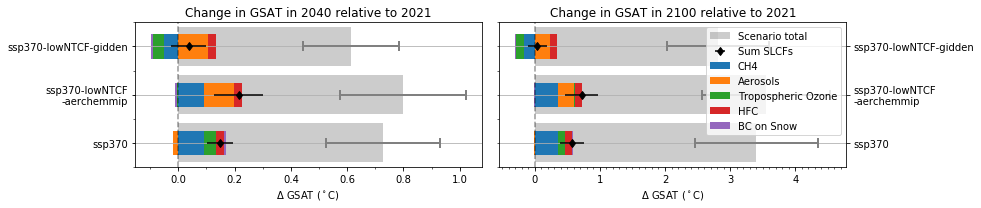

In [20]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[12, 3], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tabel_dT_anthrop.loc[yr, scenario_370].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = yerr_tot.loc[yr, scenario_370].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tabel_dT_sum_slcf.loc[yr, scenario_370].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = yerr_sum.loc[yr, scenario_370].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            xerr=tot_sd_yr.transpose()[ntot].values,
            error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    # ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values
    s_err = sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_y, s_x, xerr=s_err, label=ntot, color='k', fmt='d', linestyle="None")  # ,
    # error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tabel_dT_slcfs.loc[yr, scenario_370].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend()  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')

    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')

fn = RESULTS_DIR + '/figures/stack_bar_influence_years_horiz_errTot_370only.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y', which='minor')  # ,bottom='off')
ax.tick_params(labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)
a=2
#plt.show()